In [185]:
from ensemble_boxes import *
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [186]:
def gen_color_list(model_num, labels_num):
    color_list = np.zeros((model_num, labels_num, 3))
    colors_to_use = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (0, 0, 0)]
    total = 0
    for i in range(model_num):
        for j in range(labels_num):
            color_list[i, j, :] = colors_to_use[total]
            total = (total + 1) % len(colors_to_use)
    return color_list

In [187]:
def show_boxes(boxes_list, scores_list, labels_list, image_size=800):
    thickness = 5
    color_list = gen_color_list(len(boxes_list), len(np.unique(labels_list)))
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    image[...] = 255
    for i in range(len(boxes_list)):
        for j in range(len(boxes_list[i])):
            x1 = int(image_size * boxes_list[i][j][0])
            y1 = int(image_size * boxes_list[i][j][1])
            x2 = int(image_size * boxes_list[i][j][2])
            y2 = int(image_size * boxes_list[i][j][3])
            lbl = labels_list[i][j]
            cv2.rectangle(image, (x1, y1), (x2, y2), color_list[i][lbl], int(thickness * scores_list[i][j]))
            cv2.putText(image, str(round(scores_list[i][j],2)), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color_list[i][lbl], int(thickness * scores_list[i][j]))
    return image

# 단일 모델

In [188]:
# 단일 모델의 예측값들을 앙상블해봅니다.
# IoU threshold = 0.5
# Confidence score가 0.0001보다 낮은 box는 무시합니다.

boxes_list = [
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]
scores_list = [0.9, 0.8, 0.2, 0.4, 0.7, 0.5, 0.8, 0.7, 0.3]
labels_list = [0, 1, 0, 1, 1, 1, 1, 1, 0] # 레이블 0 과 1인 박스들은 각각 3개, 6개.

iou_thr = 0.5
sigma = 0.1

In [189]:
origin_image = show_boxes([boxes_list], [scores_list], [labels_list])

In [190]:
wbf_boxes, wbf_scores, wbf_labels = weighted_boxes_fusion([boxes_list], [scores_list], [labels_list], iou_thr=0.5, skip_box_thr=0.0001)
wbf_image = show_boxes([wbf_boxes], [wbf_scores], [wbf_labels.astype(np.int32)])

In [196]:
#########
## nms ##
#########
# iou_thr: IoU value for boxes to be a match 
# method: 1 - linear soft-NMS, 2 - gaussian soft-NMS, 3 - standard NMS
## Soft-nms: default로 2번
## NMS: 3번
# sigma: Sigma value for SoftNMS(default 0.5)
# thresh: threshold for boxes to keep (important for SoftNMS)(default 0.001)
# weights: list of weights for each model. Default: None, which means weight == 1 for each model

nms_boxes, nms_scores, nms_labels = nms([nms_boxes], [nms_scores], [nms_labels], iou_thr=0.5)
nms_image = show_boxes([nms_boxes], [nms_scores], [nms_labels.astype(np.int32)])


softnms_boxes, softnms_scores, softnms_labels = soft_nms([boxes_list], [scores_list], [labels_list],  iou_thr=0.5, sigma=0.1, thresh=0.001)
soft_nms_image = show_boxes([softnms_boxes], [softnms_scores], [softnms_labels.astype(np.int32)])


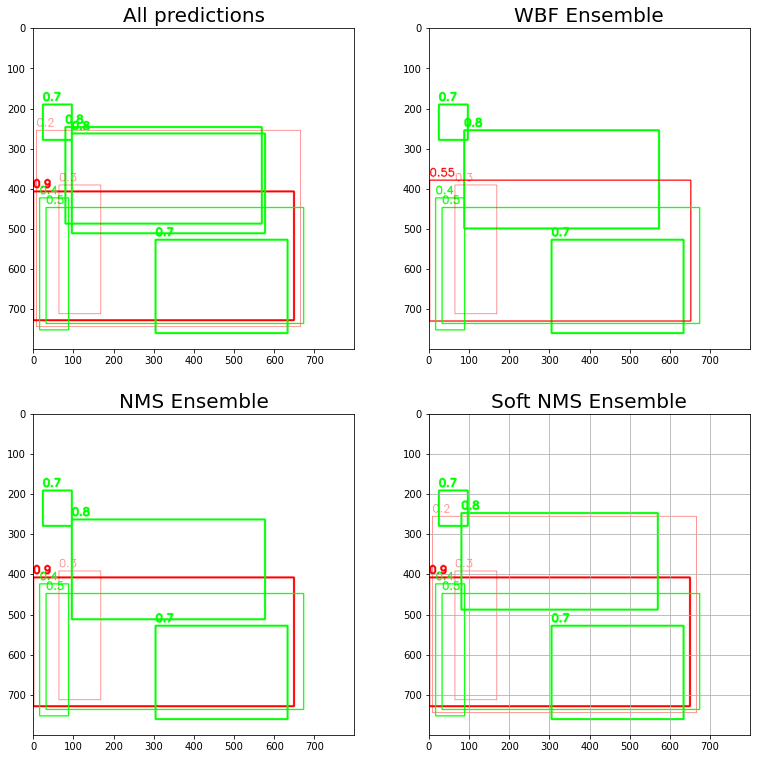

In [200]:
fig , axes = plt.subplots(2,2)
fig.set_size_inches(13,13)
axes[0][0].set_title("All predictions", fontsize=20)
axes[0][0].imshow(origin_image)

axes[0][1].set_title("WBF Ensemble", fontsize=20)
axes[0][1].imshow(wbf_image)

axes[1][0].set_title("NMS Ensemble", fontsize=20)
axes[1][0].imshow(nms_image)

axes[1][1].set_title("Soft NMS Ensemble", fontsize=20)
axes[1][1].imshow(soft_nms_image)


# 2개의 모델

In [141]:
# 2개의 모델이 존재합니다.
# 첫 번째 모델은 5개, 두 번째 모델은 4개의 bounding box를 예측했습니다.
# 첫 번째 모델의 박스별 Confidence score과 레이블: [0.9, 0.8, 0.2, 0.4, 0.7], [0, 1, 0, 1, 1]
# 두 번째 모델의 박스별 Confidence score과 레이블: [0.5, 0.8, 0.7, 0.3], [1, 1, 1, 0]
# IoU threshold = 0.5
# Confidence score가 0.0001보다 낮은 box는 무시합니다.

In [179]:
boxes_list = [[
    [0.00, 0.51, 0.81, 0.91], # 첫 번째 모델
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
],[
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]]

scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]] # class
weight = [2,1]

In [175]:
origin_image = show_boxes(boxes_list, scores_list, labels_list)

/opt/conda/envs/detection/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [181]:
wbf_boxes, wbf_scores, wbf_labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list,weights=weight, iou_thr=0.5, skip_box_thr=0.0001)
wbf_image = show_boxes([wbf_boxes], [wbf_scores], [wbf_labels.astype(np.int32)])

In [182]:
nms_boxes, nms_scores, nms_labels = nms_method(boxes_list, scores_list, labels_list, method=3, iou_thr=0.5)
nms_image = show_boxes([nms_boxes], [nms_scores], [nms_labels.astype(np.int32)])


softnms_boxes, softnms_scores, softnms_labels = nms_method(boxes_list, scores_list, labels_list, method=2, iou_thr=0.5, sigma=0.1, thresh=0.001)
soft_nms_image = show_boxes([softnms_boxes], [softnms_scores], [softnms_labels.astype(np.int32)])


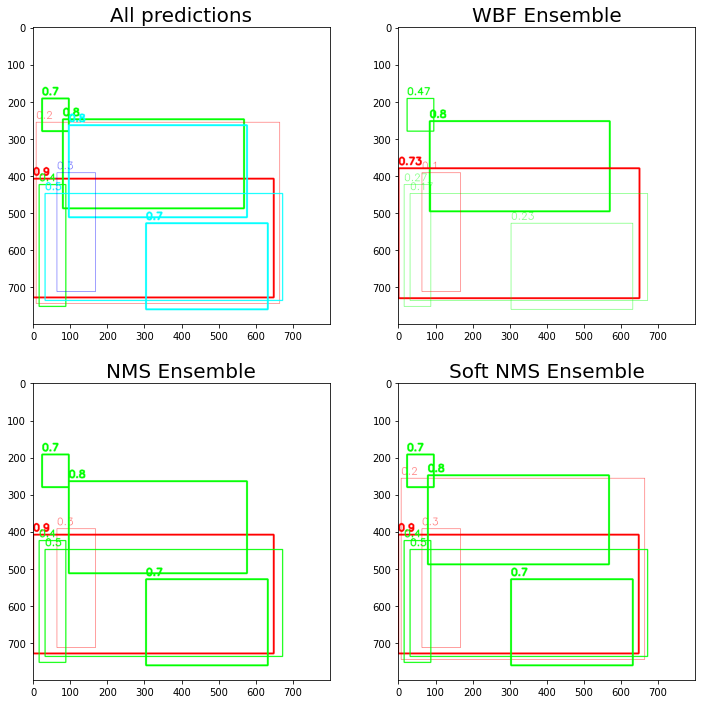

In [183]:
fig , axes = plt.subplots(2,2)
fig.set_size_inches(12,12)

axes[0][0].set_title("All predictions", fontsize=20)
axes[0][0].imshow(origin_image)

axes[0][1].set_title("WBF Ensemble", fontsize=20)
axes[0][1].imshow(wbf_image)

axes[1][0].set_title("NMS Ensemble", fontsize=20)
axes[1][0].imshow(nms_image)

axes[1][1].set_title("Soft NMS Ensemble", fontsize=20)
axes[1][1].imshow(soft_nms_image)
